This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

# Using entity embedding and neural network for prediction on structured data

## Running gpu config script is extremely important!!

If the gpu config script is not run at the beginning before other packages are loaded, Tensorflow will allocate all the available gpu memory (which is very precious) to this one process and leave other users in the cold...

In [1]:
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [2]:
import math, datetime, pandas as pd, numpy as np
from datetime import date
import calendar
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
from isoweek import Week
from pandas_summary import DataFrameSummary
from IPython.display import HTML, display, Audio
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
import sklearn.manifold
from keras.layers import Input, Dense, Flatten, Embedding, Dropout, concatenate, merge
from keras.models import Model
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins import projector
import seaborn as sns
%matplotlib inline

### checking gpu availability

In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [ ]:
!kg

In [4]:
%cd /notebooks/data/rossmann/

/notebooks/data/rossmann


In [ ]:
# before you do this you must have an account with kaggle and you should have accepted the competition rules

!kg download -u 'xxxxxxx' -p 'xxxxxxx' -c 'rossmann-store-sales'

In [ ]:
# some extra data used from google trends

!wget https://raw.githubusercontent.com/osu-msban-ai/Deep-Learning-Course-Files/master/googletrend.csv

In [ ]:
# some extra data used from weather data

!wget https://raw.githubusercontent.com/osu-msban-ai/Deep-Learning-Course-Files/master/weather.csv

In [5]:
import os
PATH = os.getcwd()

## Create datasets

Some extra tables are included in addition to the Kaggle dataset. These are:

* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather

Kaggle provided datasets are:

* train: Training set provided by Kaggle competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* test: testing set

## Using Pandas for manipulating data

For manipulating structred data we will be using Pandas. This manages dataframes like R

We're going to go ahead and load all of our csv's as dataframes into a list tables.

In [6]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

In [7]:
tables = [pd.read_csv(fname+'.csv', low_memory=False) for fname in table_names]

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [8]:
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [9]:
for t in tables: display(DataFrameSummary(t).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,NordrheinWestfalen,RP
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


## Data pre-processing

As a structured data problem, we necessarily have to go through all the cleaning and some minimal feature engineering, even though we're using a neural network.

In [10]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [11]:
len(train),len(test)

(1017209, 41088)

Turn state Holidays to Bool

In [12]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

Define function for joining tables on specific fields.

By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "_y" to those on the right.

In [13]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

Join weather/state names.

In [14]:
weather = join_df(weather, state_names, "file", "StateName")

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' with the usage in the rest of the table, 'HB,NI'.

In [15]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [16]:
def add_datepart(df):
    df.Date = pd.to_datetime(df.Date)
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Week"] = df.Date.dt.week
    df["Day"] = df.Date.dt.day

We'll add to every table w/ a date field.

In [17]:
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)
add_datepart(test)

In [18]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

We now make a single table by joining all the tables

We do an outer join, because there is a possiblity that all records for the join fields are not complete. So we do a null-catch after the join and ensure that there are no nulls

In [19]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [20]:
joined= join_df(train, store, "Store")
print(len(joined[joined.StoreType.isnull()]))

0


In [21]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
print(len(joined[joined.trend.isnull()]))

0


In [22]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
print(len(joined[joined.trend_DE.isnull()]))

0


In [23]:
joined = join_df(joined, weather, ["State","Date"])
print(len(joined[joined.Mean_TemperatureC.isnull()]))

0


In [24]:
joined_test = test.merge(store, how='left', left_on='Store', right_index=True)
len(joined_test[joined_test.StoreType.isnull()])

48

Next we'll fill in missing values to avoid complications w/ na's.

In [26]:
joined.CompetitionOpenSinceYear = joined.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
joined.CompetitionOpenSinceMonth = joined.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
joined.Promo2SinceYear = joined.Promo2SinceYear.fillna(1900).astype(np.int32)
joined.Promo2SinceWeek = joined.Promo2SinceWeek.fillna(1).astype(np.int32)

We'll now extract features "CompetitionOpenSince" and "CompetitionDaysOpen". We use a lambda function and apply() to apply computation acroos rows in the dataframe.

For large datasets this will take time since this a sequential operation and cannot parallelized

In [27]:
joined["CompetitionOpenSince"] = pd.to_datetime(joined.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1).astype(pd.datetime))
joined["CompetitionDaysOpen"] = joined.Date.subtract(joined["CompetitionOpenSince"]).dt.days

We'll replace some erroneous / outlying data.

In [28]:
joined.loc[joined.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined.loc[joined.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Added "CompetitionMonthsOpen" field, limit the maximum to 2 years to limit number of unique embeddings.

In [29]:
joined["CompetitionMonthsOpen"] = joined["CompetitionDaysOpen"]//30
joined.loc[joined.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,
        1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates.

In [30]:
joined["Promo2Since"] = pd.to_datetime(joined.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
joined["Promo2Days"] = joined.Date.subtract(joined["Promo2Since"]).dt.days

In [31]:
joined.loc[joined.Promo2Days<0, "Promo2Days"] = 0
joined.loc[joined.Promo2SinceYear<1990, "Promo2Days"] = 0

In [32]:
joined["Promo2Weeks"] = joined["Promo2Days"]//7
joined.loc[joined.Promo2Weeks<0, "Promo2Weeks"] = 0
joined.loc[joined.Promo2Weeks>25, "Promo2Weeks"] = 25
joined.Promo2Weeks.unique()

array([ 0, 25, 17,  8, 13, 24, 16,  7, 12, 23, 15,  6, 11, 22, 14,  5, 10,
       21,  4,  9, 20,  3, 19,  2, 18,  1])

## Durations

In time series data it is often necessary to extract relationships across rows e.g. running averages, time to next event, time since last event. To do this we have created a class

In [33]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

We've defined a class `elapsed` for cumulative counting across a sorted dataframe.

Given a particular field `fld` to monitor, this object will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen.

We'll see how to use this shortly.

In [34]:
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.Store != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if (row[self.fld]): self.last = row.Date
        return row.Date-self.last

In [35]:
df = train[columns]

And a function for applying said class across dataframe rows and adding values to a new column.

In [40]:
def add_elapsed(fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will generate an instance of the `elapsed` class for School Holiday:
* Instance applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another promotion.

This process will take time, since data is being manipulated across rows

In [41]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [42]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [43]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [44]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [45]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [47]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(pd.Timedelta(0)).dt.days

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [48]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [49]:
fwd = df[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [50]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [51]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [52]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [53]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [54]:
df.drop(columns,1,inplace=True)

It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [55]:
df.to_csv('df.csv')

In [56]:
df = pd.read_csv('df.csv', index_col=0)

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [57]:
df["Date"] = pd.to_datetime(df.Date)

In [58]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [59]:
joined = join_df(joined, df, ['Store', 'Date'])

We'll back this up as well.

In [60]:
%%time
joined.to_csv('joined.csv')

CPU times: user 1min 33s, sys: 540 ms, total: 1min 34s
Wall time: 1min 34s


We now have our final set of engineered features.

In [61]:
joined = pd.read_csv('joined.csv', index_col=0)
joined["Date"] = pd.to_datetime(joined.Date)
joined.columns

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE',
       'trend_DE', 'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees',
       

In [62]:
len(joined.columns)

82

## Create features

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

This dictionary maps categories to embedding dimensionality. In generally, categories we might expect to be conceptually more complex have larger dimension.

In [63]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

Name categorical variables

In [64]:
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]

Likewise for continuous

In [65]:
# mean/max wind; min temp; cloud; min/mean humid; 
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

Replace nulls w/ 0 for continuous, "" for categorical.

In [66]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""

Here we create a list of tuples, each containing a variable and an instance of a transformer for that variable.

For categoricals, we use a label encoder that maps categories to continuous integers. For continuous variables, we standardize them.

In [67]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [68]:
cat_maps[:2]

[('Store', LabelEncoder()), ('Day', LabelEncoder())]

The same instances need to be used for the test set as well, so values are mapped/standardized appropriately.

DataFrame mapper will keep track of these variable-instance mappings.

In [69]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [70]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


16

Example of first five rows of zeroth column being transformed appropriately.

In [71]:
cat_map_fit.transform(joined)[0,:5], contin_map_fit.transform(joined)[0,:5]

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


(array([ 0, 30,  4,  6,  4]),
 array([-0.53772351,  1.02444552,  0.81863226,  0.32504749,  0.61112004]))

We can also pickle these mappings, which is great for portability!

In [73]:
pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))

In [72]:
[len(o[1].classes_) for o in cat_map_fit.features]

[1115, 31, 7, 12, 12, 23, 8, 22, 2, 3, 4, 3, 25, 4, 52, 26, 6, 6, 3, 3, 8, 8]

## Sample data

In [74]:
joined_sales = joined[joined.Sales!=0]
n = len(joined_sales)

It is a good idea to try out the model on a sample 

In [ ]:
samp_size = 100000
np.random.seed(42)
idxs = sorted(np.random.choice(n, samp_size, replace=False))

In [ ]:
joined_samp = joined_sales.iloc[idxs].set_index("Date")

In [75]:
samp_size = n
joined_samp = joined_sales.set_index("Date")

In time series data, cross-validation is not random. Instead, our holdout data is always the most recent data, as it would be in real application.

We've taken the last 10% as our validation set.

In [133]:
train_ratio = 0.97
train_size = int(samp_size * train_ratio)

In [134]:
joined_valid = joined_samp[train_size:]
joined_train = joined_samp[:train_size]
len(joined_valid), len(joined_train)

(25331, 819007)

Here's a preprocessor for our categoricals using our instance mapper.

In [78]:
def cat_preproc(dat, var):
    return var.transform(dat).astype(np.int64)

In [135]:
cat_map_train = cat_preproc(joined_train, cat_map_fit)
cat_map_valid = cat_preproc(joined_valid, cat_map_fit)

Same for continuous.

In [80]:
def contin_preproc(dat, var):
    return var.transform(dat).astype(np.float32)

In [136]:
contin_map_train = contin_preproc(joined_train, contin_map_fit)
contin_map_valid = contin_preproc(joined_valid, contin_map_fit)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Grab our targets.

In [137]:
y_train_orig = joined_train.Sales
y_valid_orig = joined_valid.Sales

Finally, the authors modified the target values by applying a logarithmic transformation and normalizing to unit scale by dividing by the maximum log value.

Log transformations are used on this type of data frequently to attain a nicer shape. 

Further by scaling to the unit interval we can now use a sigmoid output in our neural network. Then we can multiply by the maximum log value to get the original log value and transform back.

In [138]:
max_log_y = np.max(np.log(joined_samp.Sales))
y_train = np.log(y_train_orig)/max_log_y
y_valid = np.log(y_valid_orig)/max_log_y

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [84]:
def rmspe(y_pred, targ = y_valid_orig):
    pct_var = (targ - y_pred)/targ
    return math.sqrt(np.square(pct_var).mean())

These undo the target transformations.

In [85]:
def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)

## Create models

Now we're ready to put together our models.

In [86]:
def split_cols(arr):
    return np.hsplit(arr,arr.shape[1])

In [139]:
# - This gives the correct list length for the model
# - (list of 23 elements: 22 embeddings + 1 array of 16-dim elements)  
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

In [ ]:
len(map_train)

Helper function for getting categorical name and dim.

In [88]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

In [89]:
cat_map_info(cat_map_fit.features[1])

('Day', 31)

Using custom initializers for embedding

In [90]:
def my_init(scale):
    return K.variable(np.random.uniform(low=-scale, high=scale, size=shape), name=name)

In [91]:
def emb_init(shape, name=None): 
    return K.variable(np.random.uniform(low=-2/(shape[1]+1), high=2/(shape[1]+1), size=shape), name=name)

Helper function for constructing embeddings. Notice commented out codes, several different ways to compute embeddings at play.

Also, note we're flattening the embedding. Embeddings in Keras come out as an element of a sequence like we might use in a sequence of words; here we just want to concatenate them so we flatten the 1-vector sequence into a vector.

In [92]:
def get_emb(feat):
    name, c = cat_map_info(feat)
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1, embeddings_initializer=emb_init)(inp))
    return inp,u

Helper function for continuous inputs.

In [93]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', kernel_initializer=my_init(1.))(inp)  # Keras 2

Let's build them.

In [140]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)

Now we can put them together. Given the inputs, continuous and categorical embeddings, we're going to concatenate all of them.

Next, we're going to pass through some dropout, then two dense layers w/ ReLU activations, then dropout again, then the sigmoid activation we mentioned earlier.

In [141]:
embs = [get_emb(feat) for feat in cat_map_fit.features]

x = concatenate([emb for inp,emb in embs] + [contin_out])
x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', kernel_initializer='uniform')(x)
x = Dense(500, activation='relu', kernel_initializer='uniform')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)



In [142]:
model_emb = Model([inp for inp,emb in embs] + [contin_inp], x)
model_emb.compile('adam', 'mean_absolute_error')

This is a multi input model as can be seen from the model summary. The inputs are 22 categoriacal variables with their embeddings which is then concatenated with the continuos variables which is one vector

In [165]:
model_emb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
Day_in (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
DayOfWeek_in (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
Month_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
State_in (

## Start training

Since we are using GPU machines we can take larger batch sizes. This will make the process faster.

However, very large batch sizes (> 512) may have accuracy problems. But with very large datasets, this may not be a major issue.

Recently a paper has been published that cliams with non-decaying learning rate, large batch sizes may not be a problem. 

In [157]:
%%time 
num_epochs = 2
hist = model_emb.fit(map_train, y_train, batch_size=64, epochs=num_epochs,
                 verbose=0, validation_data=(map_valid, y_valid), callbacks=[TQDMNotebookCallback()])


CPU times: user 22min 24s, sys: 3min 42s, total: 26min 7s
Wall time: 10min 11s


In [158]:
hist.history

{'loss': [0.006657593159431411, 0.006555414646821113],
 'val_loss': [0.008268462606593552, 0.008430603598805724]}

In [ ]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

In [ ]:
plot_train(hist)

In [ ]:
model_path = PATH+'/model/'
%mkdir -p $model_path

In [ ]:
model_emb.save_weights(model_path+'model-e'+str(num_epochs))

In [159]:
preds = np.squeeze(model_emb.predict(map_valid, 1024))

In [160]:
act_preds = log_max_inv(preds)

In [161]:
err = rmspe(act_preds, targ = y_valid_orig)

In [162]:
err

0.19956405483491974

## Visualizing the embeddings

Extract the embeddings from each input layer and make a dictionary cat variables and their embeddings 

In [163]:
all_embs = {}
cat_var_nums = len(cat_map_fit.features)
sorted_cat_vars = []
for i in range(cat_var_nums):
    each_embs = model_emb.layers[i+cat_var_nums].get_weights()[0]
    var = cat_map_fit.features[i][0]
    sorted_cat_vars.append(var)
    all_embs[var] = each_embs

In [164]:
all_embs['Year']

array([[-0.47078562,  0.93954676],
       [-0.30814278, -0.29154378],
       [ 0.6626995 , -0.22031194]], dtype=float32)

In [ ]:
sorted_cat_vars

Create metadata files for the labels of each cat variable

In [166]:
names_dict = {}
month_list = []
for i in range(12):
    mon_name = calendar.month_name[i+1]
    month_list.append(mon_name)
month_list
names_dict['Month'] = month_list

In [167]:
dow_list = []
for i in range(7):
    mon_name = calendar.day_name[i]
    dow_list.append(mon_name)
dow_list
names_dict['DayOfWeek'] = dow_list

In [168]:
store_list = []
for i in range (len(all_embs['Store'])):
    name = name = 'Store'+'# ' +str(i+1)
    store_list.append(name)
store_list[:5]
names_dict['Store'] = store_list

In [169]:
day_list = []
for i in range (len(all_embs['Day'])):
    name = name = 'Day'+'# ' +str(i+1)
    day_list.append(name)
day_list[:5]
names_dict['Day'] = day_list

In [170]:
state_list = ['Berlin', 'Baden Wuerttemberg', 'Bayern', 'Niedersachsen/Bremen', 
                'Hessen', 'Hamburg', 'Nordrhein Westfalen', 'Rheinland Pfalz',
                'Schleswig Holstein', 'Sachsen', 'Sachsen Anhalt', 'Thueringen']
names_dict['State'] = state_list

Creating the metadata path for viewing in tensorboard

In [171]:
vars_of_int = ['Store', 'Day', 'DayOfWeek', 'Month', 'State']
tb_path = '/notebooks/data/tensorboard/'


for cat_var in vars_of_int:
    
    m_path = 'metadata_'+cat_var+'.tsv'
    with open(tb_path+m_path, 'w+') as file_metadata:
        for i in range(len(all_embs[cat_var])):
            if cat_var == 'Store':
                name = cat_var+'# ' +str(i+1)
        
            if cat_var == 'Day':
                name = cat_var+'# ' +str(i+1)
                
            if cat_var == 'DayOfWeek':
                name = dow_list[i]
                
            if cat_var == 'Month':
                name = month_list[i]
                
            if cat_var == 'State':
                name = state_list[i]
                
            file_metadata.write(name + '\n')

In [ ]:
pickle.dump(all_embs, open('all_embeds.pkl', 'wb'))
pickle.dump(names_dict, open('names_dict.pkl', 'wb'))

### Using tensorboard to visualize the embeddings

In [172]:


def tb_visuals(var, name):
    sess = tf.InteractiveSession()
    
    with tf.device('/device:GPU:0'):
        embedding = tf.Variable(all_embs[var], trainable=False, name=name)
        tf.global_variables_initializer().run()

    # let us create an object to Saver class which is actually used to 
    #save and restore variables to and from our checkpoints
    saver = tf.train.Saver()

    # using file writer, we can save our summaries and events to our event file.
    writer = tf.summary.FileWriter(tb_path, sess.graph)

    # adding into projector
    config = projector.ProjectorConfig()
    embed = config.embeddings.add()
    embed.tensor_name = name

    meta_path = 'metadata'+'_'+var+'.tsv'

    embed.metadata_path = tb_path+meta_path

    # Specify the width and height of a single thumbnail.
    projector.visualize_embeddings(writer, config)

    saver.save(sess, tb_path+'model.ckpt_'+var, global_step=len(all_embs[var]))
        
    return sess
        
        

In [177]:
if sess:
    sess.close()
sess = tb_visuals('DayOfWeek', 'DayOfWeek_emb')


In [ ]:
select = [1045, 940, 428, 423]
selected = store_states.loc[store_states['Store'].isin(select)]

In [ ]:
selected.head()

### Plotting using tsne

In [ ]:
tsne = sklearn.manifold.TSNE(init='pca', random_state=0, method='exact', learning_rate=500, 
                             verbose=1, early_exaggeration=1)
Y = tsne.fit_transform(all_embs['Store'])
names = store_list
plt.figure(figsize=(20,20))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]))
plt.savefig('store_embedding1.png')

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


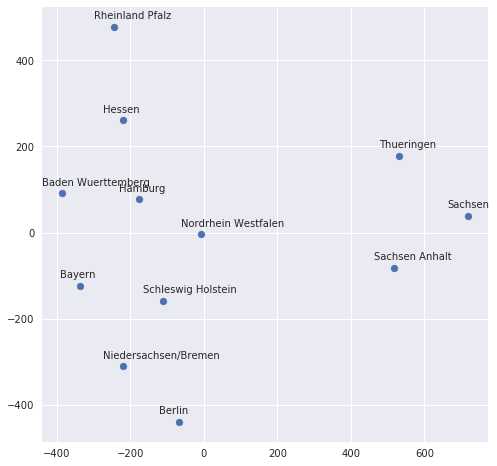

In [56]:
tsne = sklearn.manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(all_embs['State'])
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(state_list):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')
plt.savefig('state_embedding.pdf')

## XGBoost

Xgboost is extremely quick and easy to use. Aside from being a powerful predictive model, it gives us information about feature importance.

In [ ]:
X_train = np.concatenate([cat_map_train, contin_map_train], axis=1)

In [ ]:
X_valid = np.concatenate([cat_map_valid, contin_map_valid], axis=1)

In [ ]:
all_vars = cat_vars + contin_vars

In [ ]:
xgb_parms = {'learning_rate': 0.1, 'subsample': 0.6, 
             'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}

In [ ]:
xdata = xgboost.DMatrix(X_train, y_train, feature_names=all_vars)

In [ ]:
xdata_val = xgboost.DMatrix(X_valid, y_valid, feature_names=all_vars)

In [ ]:
xgb_parms['seed'] = random.randint(0,1e9)
model_xgb = xgboost.train(xgb_parms, xdata)

In [ ]:
model_xgb.eval(xdata_val)

In [ ]:
model_xgb.eval(xdata_val)

Easily, competition distance is the most important, while events are not important at all.

In real applications, putting together a feature importance plot is often a first step. Oftentimes, we can remove hundreds of thousands of features from consideration with importance plots. 

In [ ]:
importance = model_xgb.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance');

## Using Seaborn package for data exploration

This is a good tutorial on usage of Seaborn. https://www.youtube.com/watch?v=yWYWmeuH7no&index=2&list=PL998lXKj66MpNd0_XkEXwzTGPxY2jYM2d

In [ ]:
# simple example of seaborn
sns.factorplot(x ="Year", y ="Sales", hue ="Promo", data = joined,
                   size = 5, kind ="box", palette ="muted")
sns.factorplot(x ="Year", y ="Sales", hue ="SchoolHoliday", data = joined,
                   size = 5, kind ="box", palette ="muted")
